In [10]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
#import torch
import re
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
from openai import OpenAI, AsyncOpenAI

######################################
# LLM Client Setup
######################################

# Update these values according to your environment
LLM_BASE_URL = "http://10.32.15.4:31265/qwen25-32b/v1"
LLM_API_KEY = "token-abc123"

# Default Generation Parameters
DEFAULT_GEN_KWARGS = {
    "max_tokens": 2048,
    "stream": False,
    "top_p": 0.95,
    "temperature": 1.0
}

client = OpenAI(
    base_url=LLM_BASE_URL,
    api_key=LLM_API_KEY
)

######################################
# Global Instructions and Prompts
######################################

# Example JSON structure the model is expected to return
EXAMPLE_JSON = """
Example JSON format:
```json
{
  "dates": [
    {
      "year": "XXXX",
      "event": "Event description..."
    }
  ],
  "persons": [
    {
      "name": "Person Name",
      "role": "A brief role/description"
    }
  ],
  "relationships": [
    {
      "person": "Person A",
      "relationship": "nature of the relationship",
      "other_person": "Person B"
    }
  ]
}
```
"""

In [11]:

# Initial user instructions for the LLM
BASE_INSTRUCTION = """You are a highly accurate and detail-oriented assistant specialized in extracting structured historical information from documents.

Your tasks are:
1. Identify and extract all important dates and associated events from the text. 
   - Dates must be in 'YYYY' format if possible.
   - If the text provides partial or uncertain years, make a best guess.
   - Provide a brief and informative 'event' description for each date.
2. Identify and extract all important persons mentioned and their roles/positions.
3. Identify all relationships (explicit or implicit) between these persons.
4. Return the information as JSON, following the given schema.

Important:
- Include all relevant information, not just the first mention.
- Ensure the JSON is valid and strictly follows the schema.
- Do not include additional text outside of JSON.
- If necessary, reformat years (e.g., 'April 19, 1775' -> '1775').
- If you encounter missing or ambiguous information, still provide best estimates.

Finally, please provide the extracted information **only** in valid JSON format. 
Surround the JSON with triple backticks like this:
"""

In [12]:

######################################
# Preprocessing Function
######################################

def preprocess_text(text, max_length=5000):
    """
    Preprocess the input text by splitting into manageable chunks.
    This ensures that each chunk doesn't exceed the model's maximum context window.
    A paragraph-based or sentence-based splitting can be used.
    Here we do a simple paragraph-based split.
    """
    # Split by double newlines
    paragraphs = text.strip().split('\n\n')
    
    chunks = []
    current_chunk = ""
    for para in paragraphs:
        if len(current_chunk) + len(para) + 2 < max_length:
            current_chunk += para + "\n\n"
        else:
            # Store the current chunk and start a new one
            chunks.append(current_chunk.strip())
            current_chunk = para + "\n\n"
    if current_chunk.strip():
        chunks.append(current_chunk.strip())
    return chunks

In [13]:

######################################
# LLM Extraction Function
######################################

def call_llm_for_extraction(text):
    """
    Call the LLM using the OpenAI client to extract structured information.
    This function sends a chat prompt to the model and returns the raw response.
    """
    messages = [
        {"role": "system", "content": "You are a helpful assistant."},
        {"role": "user", "content": BASE_INSTRUCTION + "\n\n" + EXAMPLE_JSON + "\nDo not return any text outside of the code block."+ "\n\nText:\n" + text}
    ]

    chat_response = client.chat.completions.create(
        model="/model",
        messages=messages,
        **DEFAULT_GEN_KWARGS
    )
    return chat_response.choices[0].message.content

def parse_llm_response_to_json(generated_text):
    """
    Attempt to parse the LLM's response and extract the JSON structure.
    The LLM is instructed to return only JSON, but we add fallback parsing just in case.
    """
    # Direct JSON extraction:
    json_pattern = r'```json\s*(\{.*?\})\s*```'
    match = re.search(json_pattern, generated_text, re.DOTALL)
    if match:
        json_str = match.group(1).strip()
        try:
            structured_output = json.loads(json_str)
            return structured_output
        except json.JSONDecodeError:
            # If direct JSON parsing fails, print the error for debugging
            print("Failed to decode JSON. Raw output:\n", generated_text)
            return None
    else:
        print("No JSON found in output. Full output:\n", generated_text)
        return None

def extract_information(text, max_retries=3):
    """
    Extract information using the LLM with multiple attempts (self-correction):
    1. Call the LLM to extract JSON.
    2. If parsing fails or data is incomplete, refine the prompt and retry.
    """
    attempt = 0
    structured_output = None

    while attempt < max_retries:
        raw_output = call_llm_for_extraction(text)
        structured_output = parse_llm_response_to_json(raw_output)

        if structured_output is not None:
            # Perform a basic validation of keys
            required_keys = {"dates", "persons", "relationships"}
            if required_keys.issubset(structured_output.keys()):
                break
            else:
                print("Required keys not found. Retrying...")
        else:
            print("Parsing failed. Retrying with refinement prompt...")

        # Refine the prompt slightly in a second attempt if first fails
        attempt += 1

    return structured_output

In [14]:

######################################
# Processing & Quality Estimation
######################################

def process_text(text):
    """
    Process the entire document text by chunking and extracting info from each chunk.
    Then combine the results and perform quality checks.
    """
    chunks = preprocess_text(text)
    all_dates = []
    all_persons = []
    all_relationships = []

    # Extract from each chunk
    for chunk in chunks:
        extracted = extract_information(chunk)
        
        if not extracted:
            continue  # If extraction failed, move to next chunk

        # Check if the structure is correct
        if 'dates' not in extracted:
            extracted['dates'] = []
        if 'persons' not in extracted:
            extracted['persons'] = []
        if 'relationships' not in extracted:
            extracted['relationships'] = []
            
        if extracted:
            # Append dates
            for date_entry in extracted.get('dates', []):
                if 'year' in date_entry and 'event' in date_entry:
                    all_dates.append(date_entry)

            # Append persons
            for person_entry in extracted.get('persons', []):
                if 'name' in person_entry and 'role' in person_entry:
                    all_persons.append(person_entry)

            # Append relationships
            for relation_entry in extracted.get('relationships', []):
                if 'person' in relation_entry and 'relationship' in relation_entry and 'other_person' in relation_entry:
                    all_relationships.append(relation_entry)

    # Create DataFrames
    dates_df = pd.DataFrame(all_dates).drop_duplicates().reset_index(drop=True)
    persons_df = pd.DataFrame(all_persons).drop_duplicates(subset=['name']).reset_index(drop=True)
    relationships_df = pd.DataFrame(all_relationships).drop_duplicates().reset_index(drop=True)

    # Quality estimation & correction
    dates_df, persons_df, relationships_df = quality_estimation(dates_df, persons_df, relationships_df)

    return dates_df, persons_df, relationships_df

def validate_year(year):
    """
    Validate if the provided year is a plausible integer year.
    """
    try:
        year_int = int(year)
        # Accept years from 0 to current year for historical docs
        if 0 <= year_int <= datetime.now().year:
            return True
        return False
    except:
        return False

def quality_estimation(dates_df, persons_df, relationships_df):
    # If no dates were extracted, just return them as is
    if dates_df.empty or 'year' not in dates_df.columns:
        print("No 'year' column found in dates_df. Skipping date quality checks.")
        return dates_df, persons_df, relationships_df

    # Validate year for dates
    dates_df['valid_year'] = dates_df['year'].apply(validate_year)
    dates_df = dates_df[dates_df['valid_year']].drop(columns=['valid_year']).reset_index(drop=True)

    # Convert years to datetime
    dates_df['year_dt'] = pd.to_datetime(dates_df['year'], format='%Y', errors='coerce')
    dates_df = dates_df.dropna(subset=['year_dt']).sort_values('year_dt').reset_index(drop=True)

    # Filter relationships for known persons
    if not relationships_df.empty and {'person', 'other_person'}.issubset(relationships_df.columns):
        known_persons = persons_df['name'].unique()
        relationships_df = relationships_df[
            (relationships_df['person'].isin(known_persons)) &
            (relationships_df['other_person'].isin(known_persons))
        ].reset_index(drop=True)
    else:
        relationships_df = pd.DataFrame(columns=['person', 'relationship', 'other_person'])

    return dates_df, persons_df, relationships_df

In [15]:

######################################
# Visualization Functions
######################################

def visualize_timeline(dates_df):
    """
    Visualize events on a timeline using matplotlib.
    """
    if 'year_dt' not in dates_df.columns:
        return
    plt.figure(figsize=(12, 2))
    plt.hlines(1, dates_df['year_dt'].min(), dates_df['year_dt'].max(), colors='skyblue')
    plt.eventplot(dates_df['year_dt'], lineoffsets=1, colors='red')

    for _, row in dates_df.iterrows():
        plt.text(row['year_dt'], 1.02, row['event'], rotation=45, ha='right', va='bottom', fontsize=8)

    plt.yticks([])
    plt.xlabel('Year')
    plt.title('Events Timeline')
    plt.tight_layout()
    plt.show()

def visualize_relationships(persons_df, relationships_df):
    """
    Visualize relationships between persons using networkx and matplotlib.
    """
    G = nx.Graph()

    # Add nodes
    for _, row in persons_df.iterrows():
        G.add_node(row['name'], role=row['role'])

    # Add edges
    for _, row in relationships_df.iterrows():
        G.add_edge(row['person'], row['other_person'], relationship=row['relationship'])

    pos = nx.kamada_kawai_layout(G)

    # Calculate node sizes based on degree for better aesthetics
    degrees = dict(G.degree())
    node_sizes = [300 + degrees[node]*100 for node in G.nodes()]

    plt.figure(figsize=(14, 10))
    nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color='lightblue', alpha=0.9)
    nx.draw_networkx_edges(G, pos, width=1.5, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=10, font_family="sans-serif")

    edge_labels = nx.get_edge_attributes(G, 'relationship')
    for edge, label in edge_labels.items():
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        xm, ym = (x0 + x1) / 2, (y0 + y1) / 2
        plt.text(xm, ym, label, fontsize=9, color='black',
                 horizontalalignment='center', verticalalignment='center',
                 bbox=dict(facecolor='white', edgecolor='none', alpha=0.7))

    plt.title('Persons Relationships')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

def interactive_timeline(dates_df):
    """
    Create an interactive timeline using Plotly (optional feature).
    """
    if 'year_dt' not in dates_df.columns:
        return
    dates_df['year_str'] = dates_df['year_dt'].dt.year.astype(str)

    fig = px.scatter(dates_df, x='year_dt', y=[1]*len(dates_df),
                     text='event', title='Interactive Events Timeline',
                     labels={'x': 'Year', 'y': ''})
    fig.update_traces(textposition='top center')
    fig.update_yaxes(showticklabels=False)
    fig.update_layout(showlegend=False, height=400)
    fig.show()

def interactive_relationships(persons_df, relationships_df):
    """
    Create an interactive network graph using Plotly (optional feature).
    """
    G = nx.Graph()

    for _, row in persons_df.iterrows():
        G.add_node(row['name'], role=row['role'])

    for _, row in relationships_df.iterrows():
        G.add_edge(row['person'], row['other_person'], relationship=row['relationship'])

    pos = nx.spring_layout(G, k=0.5, seed=42)

    edge_x = []
    edge_y = []
    edge_text = []
    for edge in G.edges(data=True):
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.extend([x0, x1, None])
        edge_y.extend([y0, y1, None])
        edge_text.append(edge[2]['relationship'])

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=1, color='#888'),
        hoverinfo='text',
        text=edge_text,
        mode='lines')

    node_x = []
    node_y = []
    node_text = []
    for node in G.nodes(data=True):
        x, y = pos[node[0]]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"{node[0]} ({node[1]['role']})")

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers+text',
        text=node_text,
        textposition="top center",
        hoverinfo='text',
        marker=dict(
            showscale=False,
            color='lightblue',
            size=20,
            line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace],
                    layout=go.Layout(
                        title='Interactive Persons Relationships',
                        showlegend=False,
                        hovermode='closest',
                        margin=dict(b=20,l=5,r=5,t=40),
                        xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                        yaxis=dict(showgrid=False, zeroline=False, showticklabels=False))
                   )
    fig.show()


C:\Users\moham\AppData\Local\Temp\ipykernel_22752\3852461392.py:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


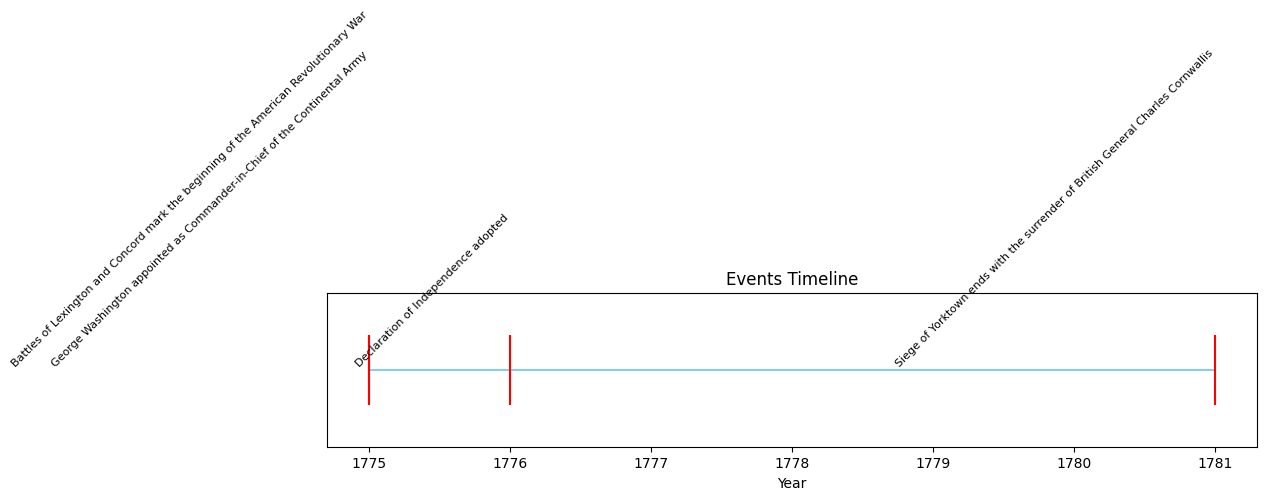

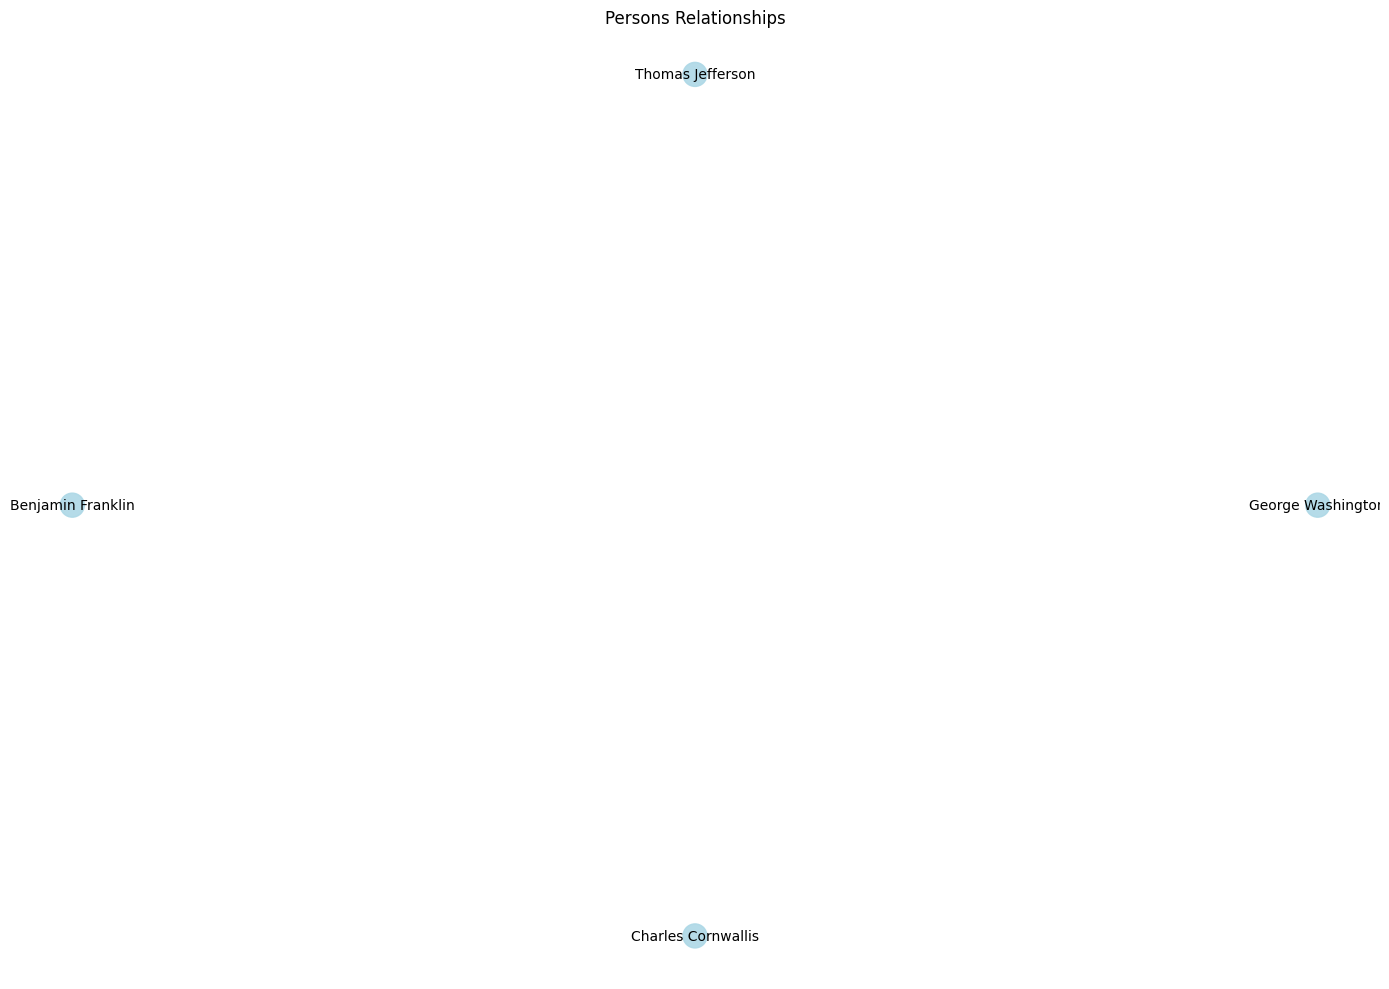

In [17]:

######################################
# Optional: LIDA Integration (Placeholder)
######################################
# Here you could integrate with LIDA for generating the visualization controls.
# For example:
#
# def call_lida_for_visualization(dates_df, persons_df, relationships_df):
#     # This function would send the data frames to LIDA and get back a function call
#     # or a control structure to render the visualizations.
#     # Placeholder for future integration.
#     pass

######################################
# Main / Example Runner
######################################

def run_example(text):
    # Process the text
    dates_df, persons_df, relationships_df = process_text(text)
    
    # Save structured data to CSV for auditing
    dates_df.to_csv('dates.csv', index=False)
    persons_df.to_csv('persons.csv', index=False)
    relationships_df.to_csv('relationships.csv', index=False)
    
    # Visualizations
    visualize_timeline(dates_df)
    visualize_relationships(persons_df, relationships_df)
    # interactive_timeline(dates_df)         # Uncomment if needed
    # interactive_relationships(persons_df, relationships_df) # Uncomment if needed

if __name__ == "__main__":
    # Example test text about the American Revolution
    test_text = """
    On April 19, 1775, the Battles of Lexington and Concord marked the beginning of the American Revolutionary War.
    George Washington was appointed as the Commander-in-Chief of the Continental Army by the Second Continental Congress in June 1775.
    In 1781, the Siege of Yorktown led to the surrender of British General Charles Cornwallis, effectively ending the war.
    Thomas Jefferson drafted the Declaration of Independence, which was adopted on July 4, 1776.
    Benjamin Franklin played a crucial role in securing French support for the American cause.
    """
    run_example(test_text)